# Density Tests

In this notebook we will be getting densities of the adjacency matrices representing the neurons in different sections of the larva (hemispheres and segments). We will then test if there is any statistical significance between the densities across hemispheres/segments.

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import seaborn as sns
from itertools import chain, combinations
from upsetplot import plot
from pathlib import Path
from matplotlib import pyplot as plt
from networkx import from_numpy_array, from_pandas_adjacency, number_of_nodes, number_of_edges, density
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.layouts import layout_tsne, layout_umap
from graspologic.plot.plot import networkplot
from graspologic.utils import is_fully_connected, largest_connected_component, is_symmetric, symmetrize
from graspologic.inference import erdos_renyi_test
from graspologic.plot import adjplot, matrixplot
from statsmodels.stats.proportion import proportion_confint, multinomial_proportions_confint
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations, load_connectome_lcc_normal_adj, load_0_adj_labels, load_1_adj_labels, load_2_adj_labels, load_3_adj_labels, load_head_adj_labels, load_pygidium_adj_labels, load_left_adj_labels, load_right_adj_labels

/Users/kareefullah/Library/Caches/pypoetry/virtualenvs/platy-data-EVeqgmAk-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


We will first load all of the adjs of the regions we are interested in: the left and right hemisphere, and for the segments, the head, pygidium, segment 1, segment 2, and segment 3. Keep in mind that these adjs represent the largest connected component of each region.

In [2]:
left_adj, _ = load_left_adj_labels()
right_adj, _ = load_right_adj_labels()
head_adj, _ = load_head_adj_labels()
pyg_adj, _ = load_pygidium_adj_labels()
#adj_0, _ = load_0_adj_labels()
adj_1, _ = load_1_adj_labels()
adj_2, _ = load_2_adj_labels()
adj_3, _ = load_3_adj_labels()

hemi_adjs = [left_adj, right_adj]
segment_adjs = [head_adj, pyg_adj, adj_1, adj_2, adj_3]

In [3]:
folder = _get_folder()
folder = Path.joinpath(folder, "density_plots")
folder

PosixPath('/Users/kareefullah/Desktop/NeuroData/neurodata/platy-data/docs/outputs/density_plots')

To keep track of the adjs easier, we separate the hemisphere and segment adjs into two dictionaries

In [4]:
#sort adjacency matrices into dicts
df_hemis = {"l": None, "r": None}
for i, key in enumerate(df_hemis):
    df_hemis[key] = hemi_adjs[i]

df_segments = {"head": None, "pygidium": None, "1": None, "2": None, "3": None}
for i, key in enumerate(df_segments):
    df_segments[key] = segment_adjs[i]


We convert the adjacency matrices to networkx objects so we can get the density of these graphs

In [5]:
nx_hemis = {"l": None, "r": None}
for key in df_hemis:
    nx_hemis[key] = from_pandas_adjacency(df_hemis[key], create_using=nx.DiGraph)

In [6]:
nx_segments = {"head": None, "pygidium": None, "1": None, "2": None, "3": None}
for key in df_segments:
    nx_segments[key] = from_pandas_adjacency(df_segments[key], create_using=nx.DiGraph)

We then get the densities of these networkx graphs

In [7]:
dens_hemis = {"l": None, "r": None}
for key in nx_hemis:
    dens_hemis[key] = density(nx_hemis[key])

hemi_keys = ["left", "right"]
#change keys
for key in hemi_keys:
    dens_hemis[key] = dens_hemis.pop(key[0])
dens_hemis

{'left': 0.0053371924258277924, 'right': 0.005479199953154931}

In [8]:
dens_segments = {"head": None, "pygidium": None, "1": None, "2": None, "3": None}
for key in nx_segments:
    dens_segments[key] = density(nx_segments[key])

We concatenate the dicts so we can get a barplot of all the dictionaries we have

In [9]:
all_dicts = dens_hemis | dens_segments

In [10]:
labels = list(all_dicts.keys())
densities = list(all_dicts.values())

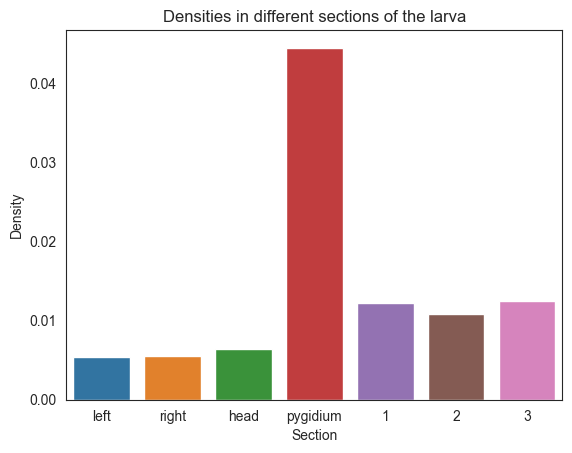

In [11]:
sns.set_style("white")
sns.barplot(x=labels, y=densities) 
plt.title("Densities in different sections of the larva")
plt.xlabel("Section")
plt.ylabel("Density")
plt.savefig(folder / "densities_sections")

The following function allows us to display confidence intervals of the barplots of hemispheres and segments

In [12]:
def plot_barplot(networks, labels, densities, coverage=0.95):
    fig, ax = plt.subplots(figsize=(6, 6))
    palette = None
    
    #barplot features

    ax.set_title("Densities in different sections of the larva")
    if len(networks) == 2:
        ax.set_xlabel("Side")
        palette = sns.color_palette("Set1")
    else:
        ax.set_xlabel("Segment")
        palette = sns.color_palette("Set2")
        
    ax.set_ylabel("Density")
    ax = sns.barplot(x=labels, y=densities, palette=palette)

    if len(networks) == 2:
        ax.set_xticklabels(["left", "right"])

    #get possible number of edges, number of edges
    possible_edges = []
    num_edges = []
    for i, network in enumerate(networks.values()):
        #possible edges
        n = np.shape(network)[0]
        n_possible = n * (n-1)
        possible_edges.append(n_possible)

        #number of edges
        num_edges.append(np.count_nonzero(network))

    #upper and lower bound for each network
    bounds = []
    for poss, num in zip(possible_edges, num_edges):
        lower, upper = proportion_confint(num, poss, alpha=1-coverage, method="beta")
        bounds.append([lower, upper])

    linewidth = 2    
    #plot confidence intervals
    for x, bound in enumerate(bounds):
        ax.plot([x, x], [bounds[x][0], bounds[x][1]], color="black", linewidth=linewidth)
    

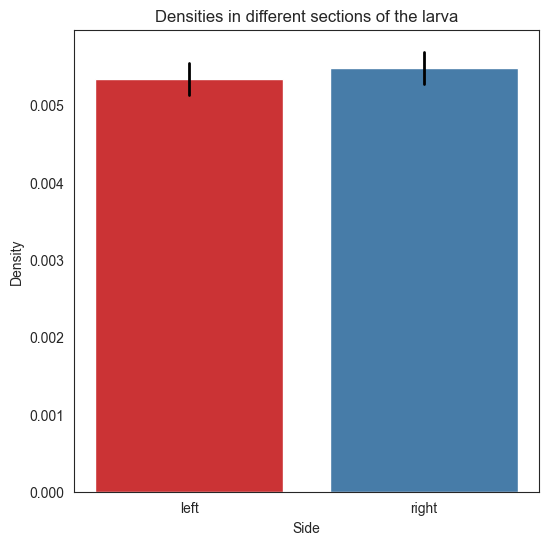

In [30]:
#bar plot for dens_hemis with confidence intervals
hemi_labels = list(dens_hemis.keys())
hemi_densities = list(dens_hemis.values())

#convert pandas df to numpy
np_hemis = {"l": None, "r": None}
for key in df_hemis:
    np_hemis[key] = df_hemis[key].to_numpy()

hemi_keys = ["left", "right"]
#change keys
for key in hemi_keys:
    np_hemis[key] = np_hemis.pop(key[0])

plot_barplot(np_hemis, hemi_labels, hemi_densities)
plt.savefig(folder / "densities_hemis")

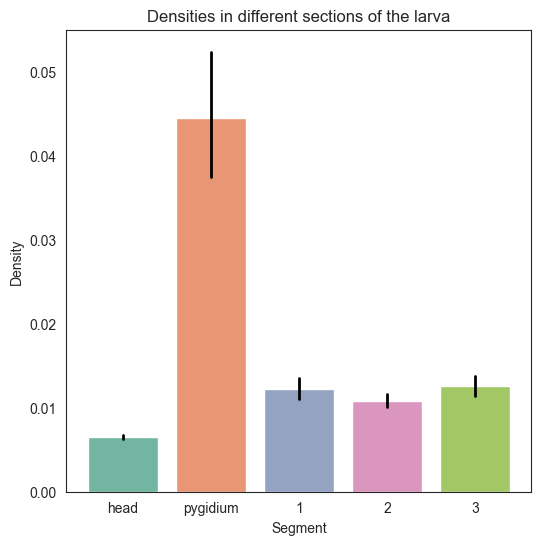

In [31]:
#bar plot for dens_segments with confidence intervals
segment_labels = list(dens_segments.keys())
segment_densities = list(dens_segments.values())

#convert pandas df to numpy
np_segments = {"head": None, "pygidium": None, "1": None, "2": None, "3": None}
for key in df_segments:
    np_segments[key] = df_segments[key].to_numpy()
plot_barplot(np_segments, segment_labels, segment_densities)
plt.savefig(folder / "densities_segments")

Let's now run the test for the left and right hemisphere

In [33]:
#print p val of er test of left vs right
stats_hemis, pval_hemis, misc_hemis = erdos_renyi_test(np_hemis["left"], np_hemis["right"])
print(pval_hemis)

0.3636771840698877


We see that the pvalue is very small, which means that we reject the null hypothesis that the edge probability for the adj of the left hemisphere is not different from the edge probability of the adj of the right hemisphere

In [34]:
#5 by 5 df of pvals of the segments
labels_segments = list(dens_segments.keys())
adj_list = list(np_segments.values())

#make pairwise combination list of all elements in list 
pairwise_labels = list(itertools.combinations(labels_segments, 2))
pairwise_adjs = list(itertools.combinations(adj_list, 2))

#initialize dataframe
names = ["head", "pygidium", "1", "2", "3"]
zero_data = np.zeros(shape=(len(names), len(names)))
pval_df = pd.DataFrame(zero_data, columns=names, index=names)
misc_df = pd.DataFrame(zero_data, columns=names, index=names)
pval_list = []
for label, adjs in zip(pairwise_labels, pairwise_adjs):
    stat, pval, misc = erdos_renyi_test(adjs[0], adjs[1])
    pval_df.loc[label[0]][label[1]] = pval
    pval_df.loc[label[1]][label[0]] = pval
    misc_df.loc[label[0]][label[1]] = misc
    misc_df.loc[label[1]][label[0]] = misc
pval_df.to_csv(folder / "er_pvals_segments.csv")
pval_df

,head,pygidium,1,2,3
head,0.000000e+00,5.854456e-66,1.171033e-27,1.887655e-31,1.345810e-32
pygidium,5.854456e-66,0.000000e+00,1.022672e-31,6.541884e-39,3.457583e-31
1,1.171033e-27,1.022672e-31,0.000000e+00,5.238621e-02,7.521865e-01
2,1.887655e-31,6.541884e-39,5.238621e-02,0.000000e+00,1.618403e-02
3,1.345810e-32,3.457583e-31,7.521865e-01,1.618403e-02,0.000000e+00


The following functions will allow us to visualize the pvalues in a heatmap, where significant p values will be denoted with an X

In [35]:
from matplotlib.transforms import Bbox
def shrink_axis(ax, scale=0.7, shift=0):
    pos = ax.get_position()
    mid = (pos.ymax + pos.ymin) / 2
    height = pos.ymax - pos.ymin
    new_pos = Bbox(
        [
            [pos.xmin, mid - scale * 0.5 * height - shift],
            [pos.xmax, mid + scale * 0.5 * height - shift],
        ]
    )
    ax.set_position(new_pos)

In [36]:
from seaborn.utils import relative_luminance
def plot_pvals(pval_df, names, multiple_correct=True, ax=None):
    if ax is None:
        width_ratios = [0.5, 3, 10]
        fig, axs = plt.subplots(
            1,
            3,
            figsize=(10, 10),
            gridspec_kw=dict(
                width_ratios=width_ratios,
            ),
        )
        axs[1].remove()
        ax = axs[-1]
        cax = axs[0]
    
    plot_pvalues = np.log10(pval_df)
    plot_pvalues.replace(-np.inf, 0, inplace=True)
    im = sns.heatmap(
        plot_pvalues,
        ax=ax,
        cmap="RdBu",
        center=0,
        square=True,
        cbar=False,
        fmt="s",
    )
    ax.set(ylabel="Source group", xlabel="Target group")

    if multiple_correct == True:
        ax.set(title="Density tests p-values segments (corrected)")
    else:
        ax.set(title="Density tests p-values segments (uncorrected)")

    ax.set(xticks=np.arange(len(names)) + 0.5, xticklabels=names)
    colors = im.get_children()[0].get_facecolors()

    shrink_axis(cax, scale=0.5, shift=0.05)
    fig = ax.get_figure()
    _ = fig.colorbar(
        im.get_children()[0],
        cax=cax,
        fraction=1,
        shrink=1,
        ticklocation="left",
    )
    cax.set_title(r"$log_{10}$" + "\ncorrected" "\np-value", pad=20)

    cax.plot(
        [0, 1], [np.log10(0.05), np.log10(0.05)], zorder=100, color="black", linewidth=3
    )

    cax.annotate(
        r"$\alpha$",
        (0.05, np.log10(0.05)),
        xytext=(-5, -2),
        textcoords="offset points",
        va="center",
        ha="right",
        arrowprops={"arrowstyle": "-", "linewidth": 3, "relpos": (0, 0.5)},
    )
    
    #make X's
    pad=0.2
    for idx, color in enumerate(colors):
        i, j = np.unravel_index(idx, (len(names), len(names)))
        if i!=j and np.log(pval_df[names[i]][names[j]]) < np.log(0.05):
            lum = relative_luminance(color)
            text_color = ".15" if lum > 0.408 else "w"
            xs = [j + pad, j + 1 - pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=4)
            xs = [j + 1 - pad, j + pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=4)
    



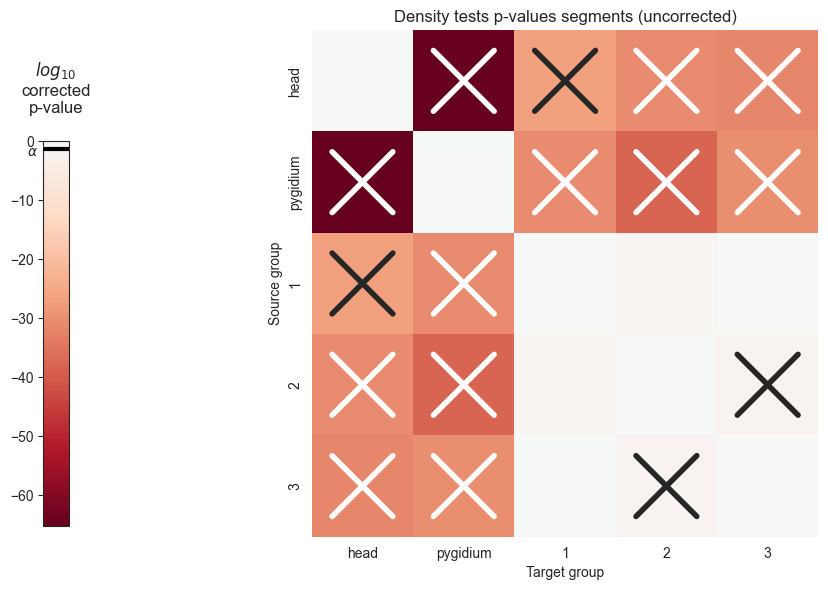

In [38]:
plot_pvals(pval_df, names, multiple_correct=False)
plt.savefig(folder / "density_heatmap_uncorrected.png")

We can see that the p values are significant across the head and pygidium, but seem mostly insignificant across the segments. Let's use bonferroni's correction on the segment p-values to reduce the chances of obtaining false positive results since we are using multiple pairwise tests 

In [39]:
#bonferroni correction for pvals
from statsmodels.stats.multitest import multipletests
np_pvals = pval_df.to_numpy().flatten()
corrected_pvals = multipletests(np_pvals)[1].reshape((len(names), len(names)))
corrected_pvals_df = pd.DataFrame(corrected_pvals, columns=names, index=names)
corrected_pvals_df.to_csv(folder / "er_corrected_pvals_segments.csv")

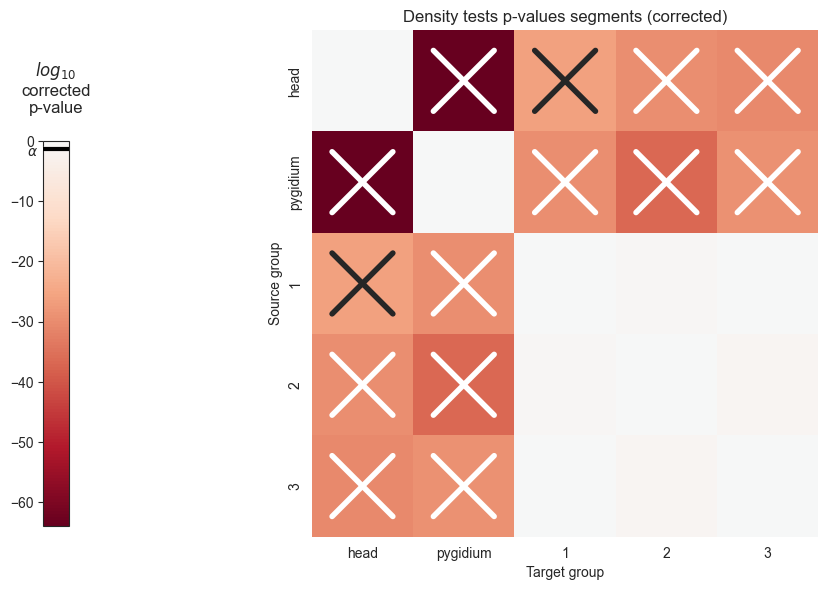

In [41]:
plot_pvals(corrected_pvals_df, names, multiple_correct=True)
plt.savefig(folder / "density_heatmap_corrected.png")

The following methods will allow us to plot the density of the sections that we are interested in, as well as the pvalue after running the `erdos_renyi_test`

In [42]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"
    

In [43]:
def plot_density_bin(pval, label1, label2, misc, method="beta", ax=None, coverage=0.95):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 6))

    n_possible_first = misc["possible1"]
    n_possible_second = misc["possible2"]

    density_first = misc["probability1"]
    density_second = misc["probability2"]

    n_edges_first = misc["observed1"]
    n_edges_second = misc["observed2"]

    first_lower, first_upper = proportion_confint(
        n_edges_first, n_possible_first, alpha=1 - coverage, method=method
    )
    second_lower, second_upper = proportion_confint(
        n_edges_second, n_possible_second, alpha=1 - coverage, method=method
    )
    

    halfwidth = 0.1
    linewidth = 4
    colors = sns.color_palette("Set2")
    palette = dict(zip([label1, label2], [colors[0], colors[1]]))

    color = palette[label1]
    x = 0
    ax.plot(
        [x - halfwidth, x + halfwidth],
        [density_first, density_first],
        color=color,
        linewidth=linewidth,
    )
    ax.plot([x, x], [first_lower, first_upper], color=color, linewidth=linewidth)

    color = palette[label2]
    x = 1
    ax.plot(
        [x - halfwidth, x + halfwidth],
        [density_second, density_second],
        color=color,
        linewidth=linewidth,
    )
    ax.plot([x, x], [second_lower, second_upper], color=color, linewidth=linewidth)

    #yticks = [np.round(density_left, 4), np.round(density_right, 4)]
    yticks = [density_first, density_second]
    ax.set(
        xlabel="Section",
        xticks=[0, 1],
        xticklabels=[label1, label2],
        xlim=(-0.5, 1.5),
        yticks=yticks,
        # ylim=(0, max(right_upper, left_upper) * 1.05),
        ylabel=r"Estimated density ($\hat{p}$)",
        title="{} vs {}; pval: {}, method: {}".format(label1, label2, pval, method)
    )
    scale = 0.04
    line_shift = 0.000005
    max_upper = max(first_upper, second_upper)
    line_start = max_upper + line_shift
    y_shift = max_upper * scale
    ax.plot([label1, label1, label2, label2], [max_upper+line_shift, max_upper+y_shift, max_upper+y_shift, max_upper+line_shift])
    text = convert_pvalue_to_asterisks(pval)
    
    x_text = 0.5
    y_text = max_upper+y_shift
    ax.text(x_text, y_text, text, ha='center', va='bottom')
    labels = ax.get_xticklabels()
    for label in labels:
        text_string = label.get_text()
        label.set_color(palette[text_string])
    return ax.get_figure(), ax

We plot the densities for adjs of the left and right hemisphere

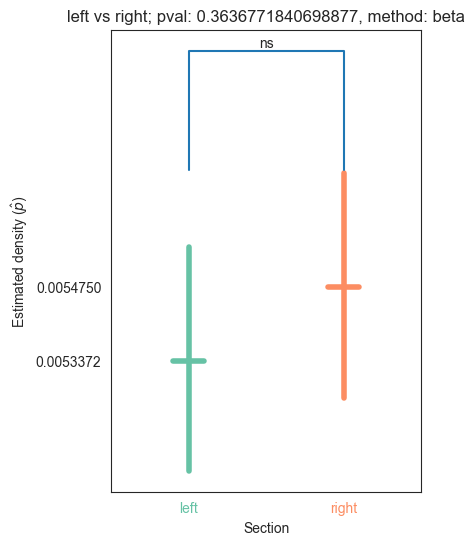

In [44]:
bin_folder = Path.joinpath(folder, "pairwise binary plots")
plot_density_bin(pval_hemis, list(np_hemis.keys())[0], list(np_hemis.keys())[1], misc_hemis, method="beta")
plt.savefig(bin_folder / "{} vs {}.png".format("left", "right"), bbox_inches='tight')

To make comparisons for the segments, we will make two lists: one that has every pairwise combination of the segment names and the other of the pairwise combination of the respective adjs

In [45]:
keys = list(np_segments.keys())
vals = list(np_segments[key] for key in keys)
keys = list(itertools.combinations(keys, 2))
vals = list(itertools.combinations(vals, 2))

We plot the densities of all the pairwise combinations of segments

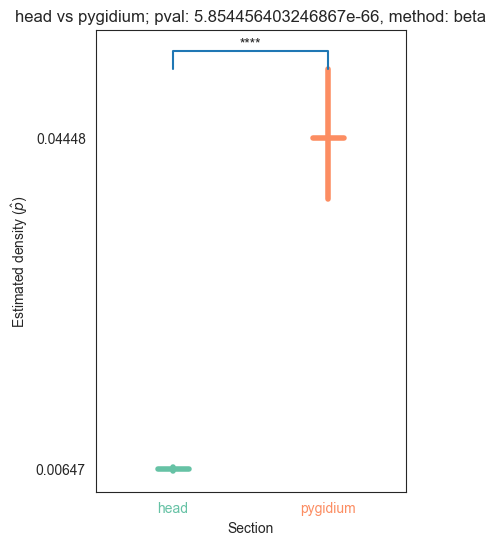

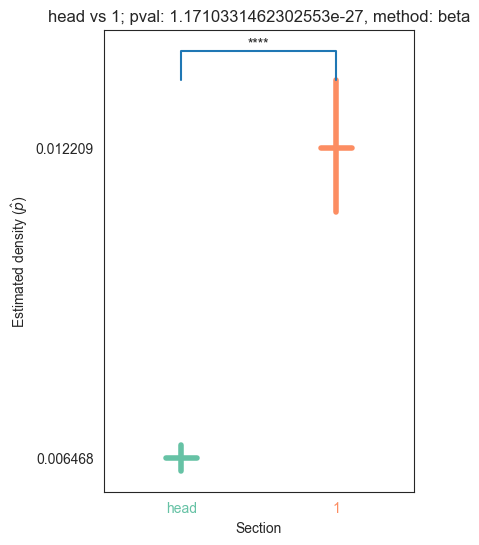

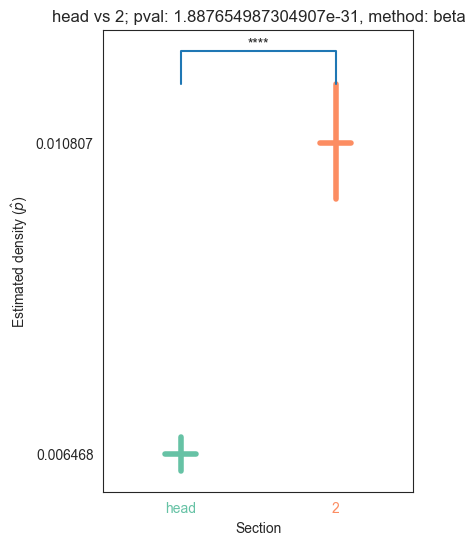

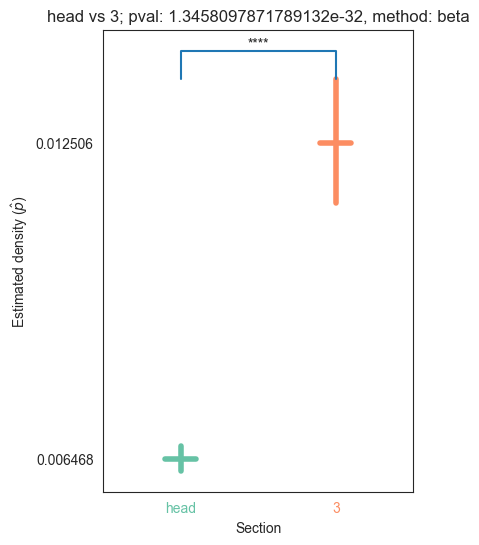

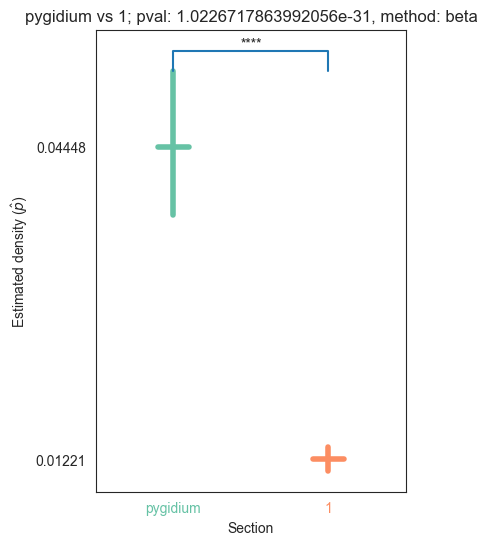

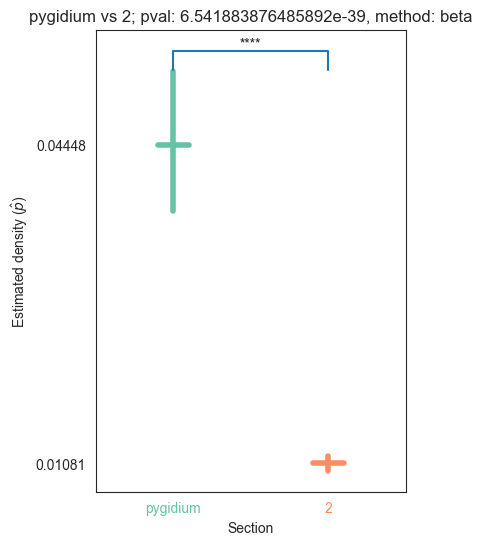

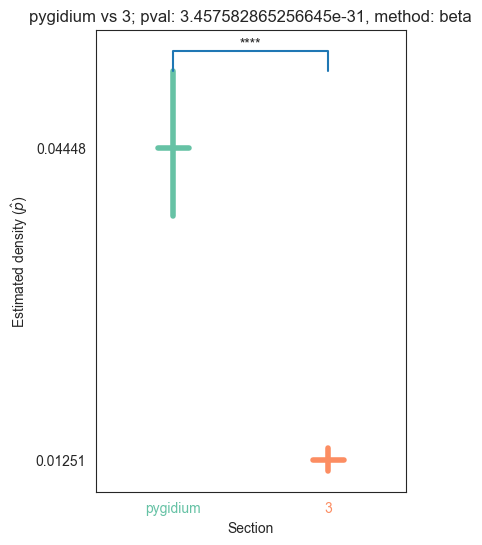

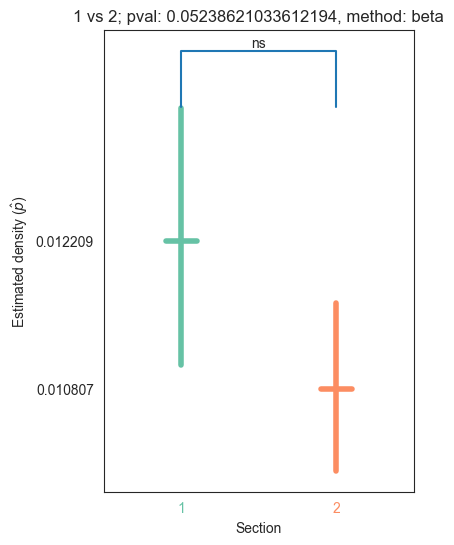

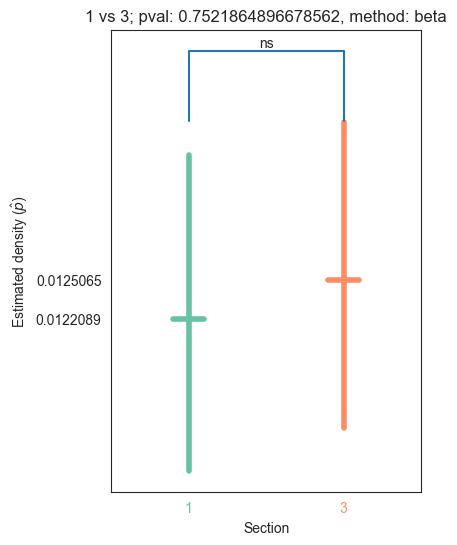

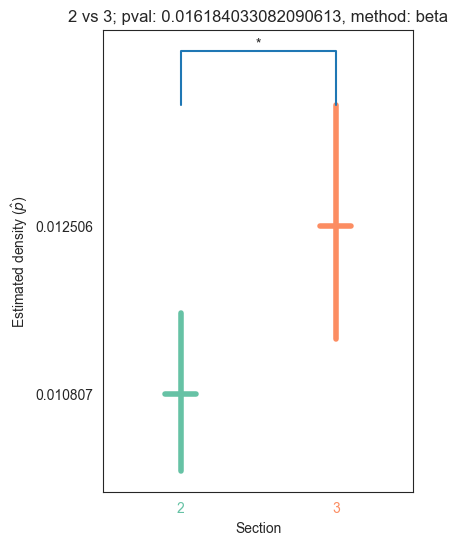

In [46]:
for pair_key, pair_val in zip(keys, vals):
    stat, pval, misc = erdos_renyi_test(pair_val[0], pair_val[1])
    plot_density_bin(pval, pair_key[0], pair_key[1], misc)
    plt.savefig(bin_folder / "{} vs {}.png".format(pair_key[0], pair_key[1]), bbox_inches='tight')

Cap off colorbars, indicate on colorbar that cap off occurs